In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("dataset/preprocessed.csv")
data = data.drop(["Unnamed: 0"], axis = 1)

In [2]:
# Find and return the correlation of the train set

def find_corr(dataset, x_train, y_train):
    names_of_features = dataset.columns
    features = x_train
    targets = y_train
    
    targets = targets.reshape(targets.shape[0], 1)
    data_np = np.append(features, targets, axis = 1)
    train_set = pd.DataFrame(data = data_np, columns = names_of_features)
    
    corr_matrix = train_set.corr()    
    sorted_feature_corr = corr_matrix["target"].sort_values(ascending = False).to_frame()
    return sorted_feature_corr

In [3]:
data_npWNan = data.iloc[:, :].values
data_np = data_npWNan[data_npWNan[:, -1] != -1]
unique_elements, counts_elements = np.unique(data_np[:, -1], return_counts = True)
print("Frequencies of the classes:")
print(np.asarray((unique_elements, counts_elements)))

Frequencies of the classes:
[[     1      2      3      4      5]
 [ 78815  87257 136412 183844 275766]]


In [4]:
feature = data_np[:, :-1]
target = data_np[:, -1]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size = 0.2, random_state = 0)

In [6]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state = 47, n_jobs = -1)
sampled_X, sampled_Y = sme.fit_resample(X_train, Y_train)

In [7]:
# 42 (+1 target) features we have
first_feature_count =           21
last_feature_count =            20
depth   =   first_feature_count     +   last_feature_count  -1  -  (first_feature_count    +   last_feature_count) // 5

In [8]:
corrs = find_corr(data, feature, target)

In [9]:
corrs

,target
target,1.000000
has_superstructure_mud_mortar_stone,0.480441
foundation_type_Mud mortar-Stone/Brick,0.445882
ground_floor_type_Mud,0.295451
other_floor_type_TImber/Bamboo-Mud,0.251744
age_building,0.208027
count_floors_pre_eq,0.188363
roof_type_Bamboo/Timber-Light_roof,0.106321
roof_type_Bamboo/Timber-Heavy_roof,0.075047
has_superstructure_stone_flag,0.065972


In [10]:
a = corrs.iloc[:, 0]
a = a.to_frame()
a.index

Index(['target', 'has_superstructure_mud_mortar_stone',
       'foundation_type_Mud mortar-Stone/Brick', 'ground_floor_type_Mud',
       'other_floor_type_TImber/Bamboo-Mud', 'age_building',
       'count_floors_pre_eq', 'roof_type_Bamboo/Timber-Light_roof',
       'roof_type_Bamboo/Timber-Heavy_roof', 'has_superstructure_stone_flag',
       'plan_configuration_Rectangular', 'height_ft_pre_eq',
       'position_Attached-1_side', 'other_floor_type_Timber-Planck',
       'ground_floor_type_Brick/Stone', 'land_surface_condition_Steep_slope',
       'land_surface_condition_Moderate_slope', 'has_superstructure_adobe_mud',
       'plan_configuration_Square', 'plan_configuration_H-shape',
       'plan_configuration_E-shape',
       'plan_configuration_Building_with_Central_Courtyard',
       'plan_configuration_U_Shape', 'plan_configuration_T_Shape',
       'position_Not_attached', 'ground_floor_type_Timber',
       'plan_configuration_Multi_Projected',
       'has_superstructure_mud_mortar_b

In [11]:
sampled_X.shape

(315389, 42)

In [12]:
# Delete features which have low correlation

for i in range(first_feature_count, corrs.shape[0] - 1 - last_feature_count):
    print("INDEX: ", i)
    index_of_feature = data.columns.get_loc(a.index[i])
    print("INDEX OF FEATURE: ", index_of_feature)
    sampled_X = np.delete(sampled_X, index_of_feature, axis = 1)
    new_x_test = np.delete(X_test, index_of_feature, axis = 1)

#sampled_X = np.delete(sampled_X, list(sampled_X.columns)[0], axis = 1)

INDEX:  21
INDEX OF FEATURE:  33


In [13]:
sampled_X.shape


(315389, 41)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

tree = [1, 5, 10, 50, 100, 250, 500]
acclist = []

for i in tree:
    model = RandomForestClassifier(n_estimators=i,
                                   n_jobs=-1,
                                   bootstrap = True,
                                   max_depth = depth,
                                   max_features = 'auto')
    
    model.fit(sampled_X, sampled_Y)
    RF_predictions =  model.predict(new_x_test)
    acc = accuracy_score(Y_test, RF_predictions)
    acclist.append(acc)
    print(i," tree")

1  tree
5  tree
10  tree
50  tree
100  tree
250  tree
500  tree


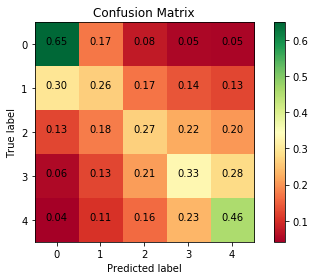

In [18]:
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, RF_predictions)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
plt.imshow(cm, interpolation = 'nearest',cmap = "RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(5):
    for j in range(5):
        plt.text(j, i, format(cm[i][j], ".2f"), horizontalalignment = "center",color = "black")

plt.tight_layout()
plt.show()

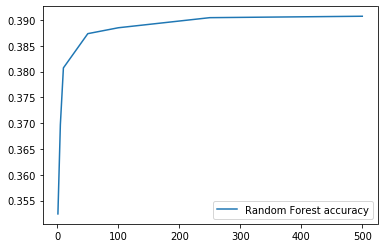

In [16]:
plt.plot(tree, acclist, label = 'Random Forest accuracy')
plt.legend()
plt.show()

In [17]:
print(acclist)

[0.3524232543186873, 0.3696914426679089, 0.3807071296885559, 0.3873401610035494, 0.38848175096280646, 0.39043688778958, 0.39071244398664207]
